# Peak-power-constrained AWGN channel

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
import math
import time
import sys
from numpy import pi,exp,sin,cos,sqrt,abs,log
from tqdm.notebook import tqdm
#%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [4]:
print(tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.4.1
Num GPUs Available:  1


In [5]:
class FCNN(tf.Module): # fully-connected ReLU net
    def __init__(self, dims, last_activation=None):
        super().__init__()
        if len(dims) < 2: raise ValueError("Input list has to be at least length 2")
        
        self.layers = []
        for i in range(len(dims)-2):
            self.layers.append(tf.keras.layers.Dense(dims[i+1], activation="relu"))
        self.layers.append(tf.keras.layers.Dense(dims[-1], activation=last_activation)) 
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def reset_weights(model): # https://github.com/keras-team/keras/issues/341
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))

# modified MINE (with additional input)

In [6]:
class MINE_mod(tf.Module):
    """
        estimates D(P||Q), where P, Q are defined on R^d 
        - MI(X;Y) if P=f_XY and Q=f_X*f_Y
        - d = dim(X) + dim(Y)
        statistics network can take additional input x
    """
    def __init__(self, dims):
        super().__init__()
        self.T = FCNN(dims) # statistics network T, input shape [B, d]
        
    def __call__(self, x_P, x_Q, x=None, averages=1): # E_P[T] - log(E_Q[e^T])
        """
            input shapes: [B, d]
            averages: number of separate averages (must be divisible by B)
        """
        if x is not None:
            if x.shape[0] % averages != 0: raise ValueError("batch size must be divisible by the number of averages")
            T1 = self.T(tf.concat([x, x_P], axis=1)) # [B, 1]
            T2 = self.T(tf.concat([x, x_Q], axis=1)) # [B, 1]
        else:
            if averages != 1: raise ValueError("number of averages should be 1 if no additional input is given")
            T1 = self.T(x_P)
            T2 = self.T(x_Q)
        
        axis_avg = 0
        if averages != 1: # returns shape [averages,]
            T1 = tf.reshape(T1, (averages, -1))
            T2 = tf.reshape(T2, (averages, -1))
            axis_avg = 1
            
        #epsilon = 1e-20 # to avoid log(0) = -Inf
        epsilon = 0
        T2 = tf.clip_by_value(T2, -1e50, 75.0)
        
        tmp = tf.reduce_mean(tf.math.exp(T2), axis=axis_avg)
        D_est = (tf.reduce_mean(T1, axis=axis_avg)-tf.math.log(epsilon+tmp)) #/tf.math.log(2.0)
        
        return D_est

# Training

In [25]:
# amplitude-limited AWGN channel
ch = 'peak-AWGN'
dims_in = 1
dims_out = 1

A = 1.0
Nx = 15
Dx = np.linspace(-A, A, Nx)
Dx_tf = tf.convert_to_tensor(Dx, dtype=tf.float32)

def cost(x): # unit cost
    return 1

def channel(x, sigma2): 
    return x + tf.random.normal(x.shape, stddev=tf.sqrt(sigma2))

def get_samples_ndt(B, sigma2):
    s = ndt(tf.random.normal([B,ndt_input])) # assumes tanh output layer
    return channel(s, sigma2)

def get_samples_ndt2(B, sigma2):
    return 5*ndt(tf.random.normal([B,ndt_input]))

In [26]:
def get_data_samples(B, sigma2):
    x_Q = get_samples_ndt(B, sigma2)
    x = [xi*tf.ones([Bx, dims_in]) for xi in Dx]
    tmp = [channel(xi, sigma2) for xi in x]
    x_P = tf.concat(tmp, axis=0)
    x = tf.concat(x, axis=0)
    return x_P, x_Q, x

In [33]:
@tf.function
def train_mine(sigma2_tf):
    x_P, x_Q, x = get_data_samples(B, sigma2_tf)
    loss = -mine(x_P, x_Q, x)
    with tf.GradientTape() as tape:
        loss = -mine(x_P, x_Q, x)
    grads = tape.gradient(loss, mine.trainable_variables)
    optimizer_mine.apply_gradients(zip(grads, mine.trainable_variables)) # weighted averaging -> TBD
    return loss

@tf.function
def train_ndt(gamma_tf, sigma2_tf):
    with tf.GradientTape() as tape:
        x_P, x_Q, x = get_data_samples(B, sigma2_tf)
        ftmp = mine(x_P, x_Q, x, averages=Nx)-gamma_tf*(cost(Dx_tf)-1)
        loss = tf.reduce_max(ftmp, axis=0)
    grads = tape.gradient(loss, ndt.trainable_variables)
    optimizer_ndt.apply_gradients(zip(grads, ndt.trainable_variables)) # weighted averaging -> TBD
    return loss

In [34]:
Bx = 20000 # samples for each value of x
B = Bx*Nx

# alternating optimization
lr = 0.001
optimizer_mine = tf.keras.optimizers.Adam(learning_rate=lr) # , clipvalue=2.0
optimizer_ndt = tf.keras.optimizers.Adam(learning_rate=lr) # , clipvalue=2.0
iter_mine_init = 200
iter_outer = 500
iter_mine = 1
iter_ndt = 1

# create NDT
n_hidden = 100
ndt_input = 50
dims_ndt = [ndt_input, n_hidden, n_hidden, dims_out]
ndt = FCNN(dims_ndt, last_activation="tanh")
ndt(tf.random.normal([B,ndt_input]))

# create MINE
dims_mine = [dims_in+dims_out, n_hidden, n_hidden, 1]
mine = MINE_mod(dims_mine)
x_P, x_Q, x = get_data_samples(B, 0.1)
mine(x_P, x_Q, x)

def Cap_wrap(gamma, SNR_dB, verbose=False):
    Cest,_ = Cap(gamma, SNR_dB, verbose)
    return Cest

def Cap(gamma, SNR_dB, verbose=False):
    sigma2 = 1/(10**(SNR_dB/10)) # peak-AWGN: SNR=A^2/sigma^2=1/sigma^2
        
    sigma2_tf = tf.convert_to_tensor(sigma2, dtype=tf.float32)
    gamma_tf = tf.convert_to_tensor(gamma, dtype=tf.float32)
    reset_weights(mine.T)
    reset_weights(ndt)
    for var in optimizer_mine.variables(): # https://stackoverflow.com/questions/39607566/reset-tensorflow-optimizer
        var.assign(tf.zeros_like(var))
    for var in optimizer_ndt.variables(): # https://stackoverflow.com/questions/39607566/reset-tensorflow-optimizer
        var.assign(tf.zeros_like(var))
    
    if verbose:
        t = tqdm(range(1, iter_outer+1))
    else:
        t = range(1, iter_outer+1)
    
    # initial MINE training
    for II in range(iter_mine_init):
        loss = -train_mine(sigma2_tf)
    if(math.isnan(loss)): print("NaN in MINE opt. (init)")
    if(math.isinf(loss)): print("Inf in MINE opt. (init)")
    
    loss_sv = []
    for i in t: # outer iterations
        for II in range(iter_mine):
            loss = -train_mine(sigma2_tf) # not a capacity estimate
        if(math.isnan(loss)): print("NaN in MINE opt. (outer iter {}): exiting loop".format(i)); break
        if(math.isinf(loss)): print("Inf in MINE opt. (outer iter {}): exiting loop".format(i)); break
            
        for II in range(iter_ndt):
            loss = train_ndt(gamma_tf, sigma2_tf) # capacity estimate
        loss_sv.append(loss.numpy())
        if(math.isnan(loss)): print("NaN in NDT opt. (outer iter {}): exiting loop".format(i)); break
        if(math.isinf(loss)): print("Inf in NDT opt. (outer iter {}): exiting loop".format(i)); break
    return loss_sv[-1], loss_sv

# evaluate upper bounds

In [35]:
SNR_dB_r = np.arange(0, 12, 1)
SNR_len = SNR_dB_r.shape[0]
runs = 5

Cest = np.zeros([SNR_len, runs])
gopt = np.zeros([SNR_len, runs])
for i in tqdm(range(SNR_len)):
    for j in tqdm(range(runs)):
        Cest[i,j],_ = Cap(0, SNR_dB_r[i], verbose=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



# Plot

(None, <matplotlib.legend.Legend at 0x7f625846bfd0>)

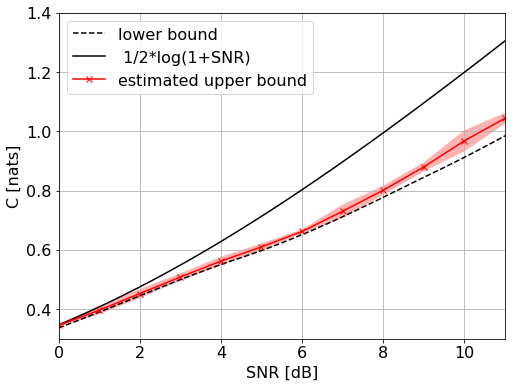

In [36]:
# PLOT AWGN
SNR_dB = np.linspace(-5,15)
SNR_r = 10**(SNR_dB/10)
C = 1/2*np.log(1+SNR_r) # [nats]

Cmean = np.mean(Cest,  axis=1)
Cstd = np.std(Cest, axis=1)

fig = plt.figure(figsize=(8, 6))

LB = np.genfromtxt('1_peak_awgn_lb.csv', delimiter=',')
plt.plot(LB[:,0], LB[:,1], color='black', linestyle='dashed', label='lower bound')

plt.plot(SNR_dB, C, color='black', label=' 1/2*log(1+SNR)')
plt.plot(SNR_dB_r, Cmean , marker='x', color='red', label='estimated upper bound')
plt.fill_between(SNR_dB_r, Cmean+2*Cstd, Cmean-2*Cstd, alpha=0.3, facecolor='red')
plt.xlabel('SNR [dB]'), plt.ylabel('C [nats]')
plt.xlim([0, 11]), plt.ylim([0.3, 1.4])
plt.grid(), plt.legend()